## Imports

In [1]:
import time
import torch.utils.data
import os
import sys
import rasterio
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import random
import re
import numpy
from tqdm import tqdm

from math import cos,pi
from sklearn.metrics import f1_score, precision_score, recall_score, jaccard_score, accuracy_score, confusion_matrix
from scipy.ndimage import morphology
from scipy.ndimage.filters import maximum_filter1d
from torch.nn import Module, Sequential
from torch.nn import Conv3d, ConvTranspose3d, BatchNorm3d, MaxPool3d, AvgPool1d, Dropout3d
from torch.nn import ReLU, Sigmoid
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import rasterio
from glob import glob
import matplotlib.pyplot as plt
from rasterio.plot import show
from tqdm import tqdm
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import math

import os
import numpy as np
import torch
import rasterio
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

from torch.utils.data import Dataset
from torch.utils.data import random_split

from scipy.stats import mode


import warnings
warnings.filterwarnings('ignore')

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
BASE_PATH = '/kaggle/input/sentinel2-crop-mapping'
FOLDERS = ['lombardia', 'lombardia2']
YEARS = ['data2016', 'data2017', 'data2018']
IMG_SIZE = (48, 48)
BANDS = 9

def is_valid_image(file):
    return file.endswith('.tif') and '_MSAVI' not in file and os.path.basename(file) != 'y.tif'

def load_image_stack(tile_path):
    # Load and stack all satellite images (ignore MSAVI)
    img_files = sorted([f for f in os.listdir(tile_path) if is_valid_image(f)])
    stack = []
    for f in img_files:
        with rasterio.open(os.path.join(tile_path, f)) as src:
            arr = src.read()  # shape: (9, 48, 48)
            stack.append(arr)
    return np.stack(stack)  # shape: (T, 9, 48, 48)

def load_mask(tile_path):
    y_path = os.path.join(tile_path, 'y.tif')
    with rasterio.open(y_path) as src:
        mask = src.read(1)
    return remap_labels(mask, label_remap) #(48,48) image with remapped labels


In [3]:
label_remap = {
    2: 0,  # Cereals
    9: 1,  # Maize
    12: 2, # Rice
    7: 3,  # Forage
    1: 4, 3: 4, 5: 4, 6: 4, 8: 4, 10: 4, 11: 4, 13: 4, 14: 4, 15: 4, 16: 4, 19: 4, 255:4,  # Unknown crop
    4: 5,  # Woods/tree crops
    17: 6, 18: 6, 20: 6, 21: 6,  # Non-agricultural
}

def remap_labels(mask, label_remap):
    return np.vectorize(lambda x: label_remap.get(x, 255))(mask).astype(np.uint8)


In [4]:
all_data = []

for region in FOLDERS:
    for year in YEARS:
        tiles_root = os.path.join(BASE_PATH, region, year)
        tile_ids = sorted(os.listdir(tiles_root))

        for tile_id in tqdm(tile_ids[:10], desc=f"{region}/{year}"):  # ← change [:10] to full load
            tile_path = os.path.join(tiles_root, tile_id)
            try:
                X = load_image_stack(tile_path)
                y = load_mask(tile_path)
                all_data.append((X, y))
            except Exception as e:
                print(f"❌ Failed to load {tile_path}: {e}")


lombardia2/data2018: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


In [5]:
label_counter = Counter()

for _, y in all_data:
    flat_labels = y.flatten()
    label_counter.update(flat_labels.tolist())

# Sort the label counts
label_counts = dict(sorted(label_counter.items()))

# ✅ Total number of unique labels
num_labels = len(label_counts)

# ✅ Total number of labeled pixels
total_pixels = sum(label_counts.values())

# 🔍 Print everything
print(f"🔢 Total unique labels: {num_labels}")
print(f"🧮 Total labeled pixels: {total_pixels}")
print("📊 Label Frequencies:")
for label, count in label_counts.items():
    print(f"  Label {label}: {count} pixels")

🔢 Total unique labels: 7
🧮 Total labeled pixels: 138240
📊 Label Frequencies:
  Label 0: 23334 pixels
  Label 1: 22003 pixels
  Label 2: 33120 pixels
  Label 3: 5191 pixels
  Label 4: 21574 pixels
  Label 5: 19636 pixels
  Label 6: 13382 pixels


In [6]:
#fixed seed
np.random.seed(13)

#80/20 split
total_len = len(all_data)
train_len = int(0.8 * total_len)
val_len = total_len - train_len
train_raw, val_raw = random_split(all_data, [train_len, val_len])

print(f"Total samples: {len(all_data)}")
print(f"Train samples: {len(train_raw)}")
print(f"Test samples:  {len(val_raw)}")

Total samples: 60
Train samples: 48
Test samples:  12


In [7]:
from collections import defaultdict

# Assume train_raw and/or val_raw is a list of (X, y) where X.shape = (T, 9, 48, 48)
# This works for any dataset (train_raw, val_raw, test_raw, etc.)
def analyze_timesteps(data):
    timestep_counts = defaultdict(int)

    for X, _ in data:
        T = X.shape[0]
        timestep_counts[T] += 1

    # Print detailed info
    print("📊 Unique Time Step Counts:")
    for T in sorted(timestep_counts):
        print(f"  T = {T}: {timestep_counts[T]} tiles")

    print(f"\n🧮 Total Unique T values: {len(timestep_counts)}")
    return timestep_counts

# Example usage
analyze_timesteps(train_raw)


📊 Unique Time Step Counts:
  T = 33: 6 tiles
  T = 34: 8 tiles
  T = 53: 19 tiles
  T = 68: 7 tiles
  T = 71: 8 tiles

🧮 Total Unique T values: 5


defaultdict(int, {53: 19, 33: 6, 68: 7, 71: 8, 34: 8})

Image sequence shape: (68, 9, 48, 48)
Ground truth shape: (48, 48)


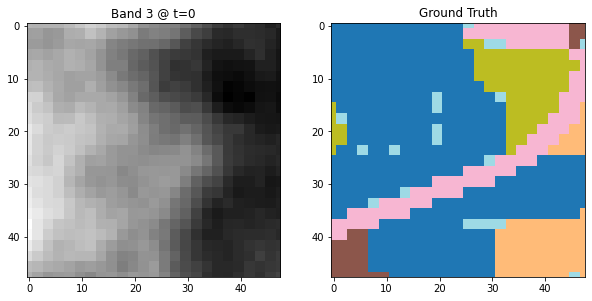

In [8]:
def plot_sample(X, y, timestep=0, band=3):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(X[timestep, band], cmap='gray')
    axs[0].set_title(f'Band {band} @ t={timestep}')
    axs[1].imshow(y, cmap='tab20')
    axs[1].set_title('Ground Truth')
    plt.show()

# Plot a sample
sample_X, sample_y = all_data[20]
print(f"Image sequence shape: {sample_X.shape}")  # (T, 9, 48, 48)
print(f"Ground truth shape: {sample_y.shape}")    # (48, 48)
plot_sample(sample_X, sample_y, timestep=0, band=3)


# Model

In [9]:
class CNNEncoder(nn.Module):
    def __init__(self, in_channels=9, out_channels=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

    def forward(self, x):  # x: (B, 9, 48, 48)
        return self.net(x)  # (B, C, 48, 48)


In [10]:
class CNN_LSTM_Segmentation(nn.Module):
    def __init__(self, cnn_feat_dim=64, lstm_hidden=64, num_classes=7):
        super().__init__()
        self.cnn = CNNEncoder()
        self.lstm = nn.LSTM(input_size=cnn_feat_dim, hidden_size=lstm_hidden,
                            batch_first=True, bidirectional=True)
        self.classifier = nn.Conv2d(lstm_hidden*2, num_classes, kernel_size=1)

    def forward(self, x):  # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape

    # Extract spatial features from each image
        feat_seq = []
        for t in range(T):
            feat = self.cnn(x[:, t])  # (B, feat_dim, H, W)
            feat_seq.append(feat)
        feat_seq = torch.stack(feat_seq, dim=1)  # (B, T, feat_dim, H, W)

    # Prepare for LSTM
        feat_seq = feat_seq.permute(0, 3, 4, 1, 2)  # (B, H, W, T, feat_dim)
        feat_seq = feat_seq.reshape(B * H * W, T, -1)  # (B*H*W, T, feat_dim)

        lstm_out, _ = self.lstm(feat_seq)  # (B*H*W, T, 2H)
        lstm_last = lstm_out[:, -1, :]     # (B*H*W, 2H) seleetcing last timestep

        
        lstm_last = lstm_last.view(B, H, W, -1).permute(0, 3, 1, 2)  # (B, 128, H, W)
        out = self.classifier(lstm_last)   # (B, num_classes, H, W)
          # Conv2d: (B, num_classes, H, W)
        return out


In [11]:
class TemporalPatchDataset(Dataset):
    def __init__(self, X, y, window_T=10, stride_T=4, crop_size=16, crop_stride=16):
        self.X = X  # shape: (T, 9, 48, 48)
        self.y = y  # shape: (48, 48)
        self.window_T = window_T
        self.stride_T = stride_T
        self.crop_size = crop_size
        self.crop_stride = crop_stride
        self.samples = []

        T, _, H, W = X.shape
        for t in range(0, T - window_T + 1, stride_T):
            for i in range(0, H - crop_size + 1, crop_stride):
                for j in range(0, W - crop_size + 1, crop_stride):
                    self.samples.append((t, i, j))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        t, i, j = self.samples[idx]
        x_patch = self.X[t:t+self.window_T, :, i:i+self.crop_size, j:j+self.crop_size]
        y_patch = self.y[i:i+self.crop_size, j:j+self.crop_size]
        return torch.tensor(x_patch, dtype=torch.float32), torch.tensor(y_patch, dtype=torch.long)


# Training

In [20]:
window_size = 10
stride = 4
crop_size = 16
crop_stride = 16
batch_size = 8

train_loaders = build_patch_loaders_by_T(train_raw, window_size, stride, crop_size, crop_stride, batch_size, shuffle=True)
val_loaders = build_patch_loaders_by_T(val_raw, window_size, stride, crop_size, crop_stride, batch_size, shuffle=False)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN_LSTM_Segmentation().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

from tqdm import tqdm
import torch
import torch.nn.functional as F

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    print(f"Epoch {epoch + 1}/{num_epochs}")

    for T_val, group_loader in tqdm(train_loaders, desc="Training - Timestep Groups"):
        for X_tile, y_tile in group_loader:
            X_tile = X_tile.to(device)        # (B, T, C, H, W)
            y_tile = y_tile.to(device)        # (B, H, W)

            B, T, C, H, W = X_tile.shape
            sum_logits = None
            count = 0

            # Sliding window inference
            for i in range(0, T - window_size + 1, stride):
                window = X_tile[:, i:i + window_size]  # (B, window_size, C, H, W)
                logits = model(window)                 # (B, num_classes, H, W)

                if sum_logits is None:
                    sum_logits = logits
                else:
                    sum_logits += logits
                count += 1

                del window, logits
                torch.cuda.empty_cache()

            avg_logits = sum_logits / count
            loss = criterion(avg_logits, y_tile)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                preds = avg_logits.argmax(dim=1)  # (B, H, W)
                train_correct += (preds == y_tile).sum().item()
                train_total += y_tile.numel()

            train_loss += loss.item() * B

            del X_tile, y_tile, sum_logits, avg_logits, preds, loss
            torch.cuda.empty_cache()

    avg_train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ------ Validation ------
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    for T_val, group_loader in tqdm(val_loaders, desc="Validation - Timestep Groups"):
        for X_tile, y_tile in group_loader:
            X_tile = X_tile.to(device)
            y_tile = y_tile.to(device)

            B, T, C, H, W = X_tile.shape
            sum_logits = None
            count = 0

            with torch.no_grad():
                for i in range(0, T - window_size + 1, stride):
                    window = X_tile[:, i:i + window_size]
                    logits = model(window)

                    if sum_logits is None:
                        sum_logits = logits
                    else:
                        sum_logits += logits
                    count += 1

                    del window, logits
                    torch.cuda.empty_cache()

                avg_logits = sum_logits / count
                loss = criterion(avg_logits, y_tile)
                preds = avg_logits.argmax(dim=1)

                val_correct += (preds == y_tile).sum().item()
                val_total += y_tile.numel()
                val_loss += loss.item() * B

            del X_tile, y_tile, sum_logits, avg_logits, preds, loss
            torch.cuda.empty_cache()

    avg_val_loss = val_loss / val_total
    val_acc = val_correct / val_total
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


Train Loss: 0.0070 | Train Acc: 0.2857


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Val Loss: 0.0089 | Val Acc: 0.1557
Epoch 2/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Train Loss: 0.0070 | Train Acc: 0.2792


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]


Val Loss: 0.0085 | Val Acc: 0.1557
Epoch 3/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.79s/it]


Train Loss: 0.0070 | Train Acc: 0.2864


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Val Loss: 0.0086 | Val Acc: 0.1557
Epoch 4/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.77s/it]


Train Loss: 0.0070 | Train Acc: 0.2801


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val Loss: 0.0088 | Val Acc: 0.1557
Epoch 5/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.74s/it]


Train Loss: 0.0070 | Train Acc: 0.2887


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.97it/s]


Val Loss: 0.0084 | Val Acc: 0.1557
Epoch 6/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.78s/it]


Train Loss: 0.0070 | Train Acc: 0.2823


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.99it/s]


Val Loss: 0.0087 | Val Acc: 0.1557
Epoch 7/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


Train Loss: 0.0070 | Train Acc: 0.2842


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.92it/s]


Val Loss: 0.0085 | Val Acc: 0.1557
Epoch 8/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:14<00:00,  2.81s/it]


Train Loss: 0.0070 | Train Acc: 0.2846


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.96it/s]


Val Loss: 0.0083 | Val Acc: 0.1557
Epoch 9/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:13<00:00,  2.75s/it]


Train Loss: 0.0070 | Train Acc: 0.2822


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Val Loss: 0.0083 | Val Acc: 0.1557
Epoch 10/10


Training - Timestep Groups: 100%|██████████| 5/5 [00:14<00:00,  2.80s/it]


Train Loss: 0.0070 | Train Acc: 0.2858


Validation - Timestep Groups: 100%|██████████| 5/5 [00:02<00:00,  1.95it/s]

Val Loss: 0.0082 | Val Acc: 0.1557


# Evalutaion

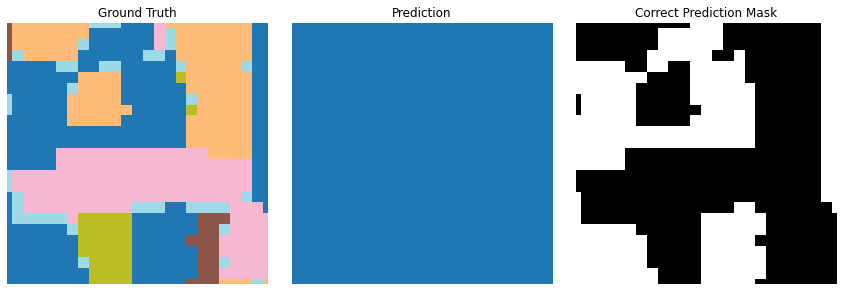

Evaluating: 100%|██████████| 48/48 [00:16<00:00,  2.89it/s]

Pixel-wise Accuracy: 0.1766673900462963

Class-wise IoU:
Cereals: 0.177
Maize: 0.000
Rice: 0.000
Forage: 0.000
Unknown crop: 0.000
Woods/tree crops: 0.000
Non-agricultural: 0.000


In [27]:
def visualize(model, dataset, idx=0, num_classes=7, label_names=None, window_size=25, stride=1):
    model.eval()
    
    # Get one sample
    X, y = dataset[idx]
    X = torch.tensor(X).float().to(device)      # (T, 9, 48, 48)
    y = torch.tensor(y).long().numpy()          # (48, 48)

    # Sliding window inference
    T = X.shape[0]
    logits_sum = torch.zeros((num_classes, 48, 48), device=device)
    count = 0

    for start in range(0, T - window_size + 1, stride):
        window = X[start:start + window_size]   # (window_size, 9, 48, 48)
        window = window.unsqueeze(0)            # Add batch dim → (1, T, 9, 48, 48)

        with torch.no_grad():
            logits = model(window)[0]           # (C, 48, 48)
        logits_sum += logits
        count += 1

    pred = logits_sum.argmax(0).cpu().numpy()   # (48, 48)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(y, cmap='tab20')
    axs[0].set_title("Ground Truth")

    axs[1].imshow(pred, cmap='tab20')
    axs[1].set_title("Prediction")

    axs[2].imshow(y == pred, cmap='gray')
    axs[2].set_title("Correct Prediction Mask")

    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()




def evaluate_full_dataset(model, dataset, num_classes=7, label_names=None, window_size=25, stride=1):
    model.eval()
    total_cm = np.zeros((num_classes, num_classes), dtype=np.int64)

    with torch.no_grad():
        for X, y in tqdm(dataset, desc="Evaluating"):
            X = torch.tensor(X).float().to(device)   # (T, 9, 48, 48)
            y_np = torch.tensor(y).long().numpy().flatten()  # (48*48,)

            T = X.shape[0]
            logits_sum = torch.zeros((num_classes, 48, 48), device=device)
            count = 0

            for start in range(0, T - window_size + 1, stride):
                window = X[start:start + window_size]  # (window_size, 9, 48, 48)
                window = window.unsqueeze(0)           # (1, T, 9, 48, 48)
                logits = model(window)[0]              # (C, 48, 48)
                logits_sum += logits
                count += 1

            pred = logits_sum.argmax(0).cpu().numpy().flatten()  # (48*48,)
            cm = confusion_matrix(y_np, pred, labels=np.arange(num_classes))
            total_cm += cm

    acc = np.trace(total_cm) / np.sum(total_cm)
    print("Pixel-wise Accuracy:", acc)

    if label_names:
        print("\nClass-wise IoU:")
        for i in range(num_classes):
            TP = total_cm[i, i]
            FP = total_cm[:, i].sum() - TP
            FN = total_cm[i, :].sum() - TP
            denom = TP + FP + FN
            iou = TP / denom if denom > 0 else 0
            print(f"{label_names[i]}: {iou:.3f}")




label_names = {
    0: "Cereals",
    1: "Maize",
    2: "Rice",
    3: "Forage",
    4: "Unknown crop",
    5: "Woods/tree crops",
    6: "Non-agricultural"
}

visualize(model, train_raw, idx=9, num_classes=7, label_names=label_names)
evaluate_full_dataset(model,  train_raw, num_classes=7, label_names=label_names)


# Loading Model

In [ ]:
epoch = 10
model.load_state_dict(torch.load(f"model_epoch_{epoch}.pth"))
model.to(device)
